# K-Means and Gaussian Mixture Models

## Proposed Method

We will first use the k-means clustering algorithm to produce the mean values that we will use to initialize our GMMs, followed by Expectation Maximization to calculate the covariances of the GMMs.

## Step 0: Data Preparation and Exploration

After importing our basic utility libraries and dataset, we plot our data to get an understanding of what kind of models we should be working with. 

We will first work with the Synthetic data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

INF = 99999999
train_data = np.loadtxt("Synthetic/29/train.txt",delimiter=",")
train_data_classes = np.asarray([train_data[np.where(train_data[:,2]==i)] for i in [1,2]])

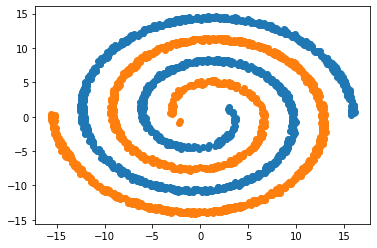

In [2]:
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.show()

As we can clearly see above, using k-means clustering on this dataset with 2 clusters will yield disastrous results.

Hence, we will instead use k-means to initialize our mean positions and then utilize them to generate GMMs.

## Step 1: Implementing $k$-means clustering

This step is slightly complex, so reading through the comments will be more useful to follow along.

We essentially make use of numpy broadcasting and indexing to vectorize our entire operation which speeds it up tremendously. 

Vectorization enables our code to be generalized to work with any $d$ dimensional dataset, with any choice of $k$, and any dataset size $n$. The only thing required is for each data example to be provided in the form `[x1, x2, x3, ... xn, class]`

In [3]:
def k_means(data,k=15):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances with some broadcasting magic
    dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new):
            break
    print(f"Iterations to convergence = {c}")
    return kmeans, r_nk_new

Now we will see what kind of means we have got from this, and whether we should use more or less complex values of $k$.

Iterations to convergence = 52
Iterations to convergence = 35


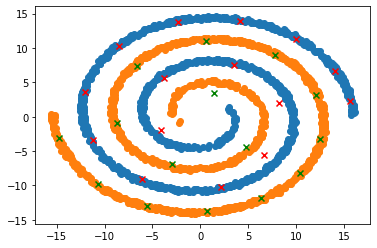

In [4]:
k = 15
means0,allotments0 = k_means(train_data_classes[0,:,:], k)
means1,allotments1 = k_means(train_data_classes[1,:,:], k)
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
plt.show()

## What happens when we use other values of $k$

### Larger values of $k$

This is expected to be more accurate and closely fit the data, but will make our GMM covariance calculation step extremely lengthy.

In [78]:
# # larger k values:

# means0,allotments0 = k_means(train_data_classes[0,:,:],30)
# means1,allotments1 = k_means(train_data_classes[1,:,:],30)
# plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
# plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
# plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
# plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
# plt.show()

As seen above, too large a value of $k$, while being extremely accurate, is not necessary as there are too many cluster centers in a very small region, which is unnecessary and will slow us down tremendously while calculating the GMM covariances.

### Smaller values of $k$

This is expected to too inaccurate to fit the data, and may actually yield worse performance than baseline (<50%) but will make our GMM covariance calculation step much faster.

In [79]:
# # smaller k values:

# means0,allotments0 = k_means(train_data_classes[0,:,:],5)
# means1,allotments1 = k_means(train_data_classes[1,:,:],5)
# plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
# plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
# plt.scatter(means0[:,0],means0[:,1],c='r',marker='x')
# plt.scatter(means1[:,0],means1[:,1],c='g',marker='x')
# plt.show()

As clearly seen above, the cluster centers for too small a value of $k$ leads to the means being in the totally opposite distribution, which would actually give us worse performance than a baseline of 50%

## Expectation Maximization for Gaussian Mixtures

We start by creating a function to calculate the gaussian probability distribution for a given dataset, its mean and its covariance.
Note that since we calculate an inverse, this slows down our code tremendously.


We also create a function to calculate the covariance for given data, but this function is only used once.

In [5]:
from scipy.stats import multivariate_normal as muno

# class PDF:
#     def __init__(self, mean, cov):
#         self.mean = mean
#         self.cov = cov
#         self.cov_det = cov[0,0]*cov[1,1] - cov[1,0]*cov[0,1]
#         self.cov_det_sqrt_inv = 1/(self.cov_det ** 0.5)
#         self.cov_inv = np.array([[cov[1,1], -cov[0,1]], [-cov[1,0], cov[0,0]]])/self.cov_det
#         self.two_pi_inv = 1/(2*np.pi)
        
#     def p(self, x):
#         return self.two_pi_inv * self.cov_det_sqrt_inv * np.exp(-0.5*(x-self.mean).T @ self.cov_inv @ (x-self.mean))

def gaussian(x,mean,cov):
    mean = np.reshape(mean[:-1],[1,-1])
    x_mu = np.squeeze(x - mean)
    D = x_mu.shape[-1]
    covinv = np.linalg.pinv(cov)
    #print(f"x_mu {x_mu.shape}, covinv: {covinv.shape}")
    n_n = 1/(2*np.pi)**(D/2) / np.linalg.det(cov)**(1/2) * np.exp(-0.5 * x_mu @ covinv @ x_mu.T)
    return np.diagonal(n_n)

def gaussian2(x,mean,cov):
    D = len(mean)
    x_mu = x-mean
    covinv = np.linalg.pinv(cov)
    return (1/((2*np.pi)**(D/2) * np.linalg.det(cov)**(0.5))) * np.exp(-0.5 * (x_mu @ covinv @ x_mu.T))

def cov(data):
    D = data.shape[-1]
    N = data.shape[0]
    # part 1: calculating means
    means = np.squeeze(np.sum(data[:,0:D],axis=0))/data.shape[0]
    # part 2: calculating covariances
    x = np.squeeze(data[:,0:D])
    covs = ((x - means).T @ (x - means))/(N-1)
    return covs

The $\pi_k$ matrix is initialized with values from the k-means estimate:

$$\pi_k = \frac{N_k}{N}$$

The covariances are initialized using the covariance function we created above, and the data is reshaped in order to allow easy numpy broadcasting.

We then calculate the initial value of the log likelihood as:

$$\sum_{n=1}^{N}\ln \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x_n}|\mathbf{\mu_k,\Sigma_k}) \right)$$

After this, we perform the E and M steps as detailed in Bishop.

We check if the new and old log likelihoods are different by more than $10^{-6}$ as our convergence criterion.

**Note:** We have aimed to vectorize the code as much as possible, and hence don't use many `for-loops` in the code. Many operations are done over the entire 

In [6]:
print(gaussian2(np.array([1,1]), np.array([1,1]), np.array([[1,0], [0,1]])))
# print(gaussian(np.array([1,1]), np.array([1,1]), np.array([[1,0], [0,1]])))

0.15915494309189535


In [7]:
def EM(data,means,allotments):
    # calculate the number of points allotted to each cluster
    Nk = np.sum(allotments,axis=0)
    Nk = np.reshape(Nk,[-1,1])
    # initialize pi_k
    N = data.shape[0]
    pi_k = Nk/N
    # find D and k
    k = means.shape[0]
    D = data.shape[-1]-1
    # create x without the classes of data:
    x = data[:,0:D]
    means = means[:,0:D]
    # initialize cov_k
    cov_k = np.array([cov(x)]*k)
    # initialize log likelihood
    ll_old = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)],axis=1)),axis=0)
    while True:
        # E Step:
        deno_g = np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)],axis=0)
        gammas = np.array([pi_k[i] * gaussian(x,means[i],cov_k[i]) for i in range(k)]) / deno_g
        # M Step:
        Nk = np.sum(gammas,axis=1)
        Nk = np.reshape(Nk,[-1,1])
        means = 1/Nk * gammas @ x
        cov_k = 1/np.expand_dims(Nk,2) * np.array([np.reshape(gammas[i],[1,-1]) * (x - means[i,:-1]).T@(x-means[i,:-1]) for i in range(k)])
        pi_k = Nk/N
        # log likelihoods
        ll_new = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)],axis=1)),axis=0)
        print(f"ll_new: {ll_new},\nll_old: {ll_old}")
        if np.abs(ll_new - ll_old) < 1e-6:
            break
        ll_old = ll_new.copy()
    return means,cov_k

In [8]:
def EM_2(data,means,allotments):
    
    # Iteration counter
    ct = 0

    # calculate the number of points allotted to each cluster
    Nk = np.sum(allotments,axis=0)
    Nk = np.reshape(Nk,[-1,1])
    
    # initialize pi_k
    N = data.shape[0]
    pi_k = Nk/N
    
    # find D and k
    k = means.shape[0]
    D = data.shape[-1]-1
    
    # create x without the classes of data:
    x = data[:,0:D]
    means = means[:,0:D]
    
    # initialize cov_k
    cov_k = np.array([cov(x)]*k)
    
    # initialize log likelihood
    ll_old = -INF
    
    while True:
        ct += 1
        # E Step:
        deno_g = np.sum([pi_k[j] * muno.pdf(x,means[j],cov_k[j]) for j in range(k)],axis=0).reshape([1,-1])
        gammas = np.array([pi_k[i] * muno.pdf(x,means[i],cov_k[i]) for i in range(k)]) / deno_g
        
        # M Step:
        Nk = np.sum(gammas,axis=1).reshape([-1,1])

        means = np.array([(1/Nk[k_ind])*np.sum([gammas[k_ind][n_ind]*x[n_ind] for n_ind in range(x.shape[0])], axis=0) for k_ind in range(Nk.shape[0])])
        cov_k = np.array([(1/Nk[k_ind])*np.sum([gammas[k_ind][n_ind]*(x[n_ind]-means[k_ind]).reshape([-1,1]) @ (x[n_ind]-means[k_ind]).reshape([-1,1]).T for n_ind in range(x.shape[0])], axis=0) for k_ind in range(Nk.shape[0])])
        
        pi_k = Nk/N

        # Compute Likelihood again
        try:
            ll_new = np.sum(np.log(np.sum([pi_k[j] * muno.pdf(x,means[j],cov_k[j]) for j in range(k)], axis=1)))
        except:
            print("Linalg error, mostly singular matrix")
            print("Cov_k:\n", cov_k)
            print([np.linalg.det(cov_k[k_ind]) for k_ind in range(Nk.shape[0])])
            break
        #print(f"iter {ct}, ll_new: {ll_new}")

        # Termination condition
        if np.abs(ll_new - ll_old) < 1e-6 or ll_new < ll_old or ct == 100:
            break

        ll_old = ll_new.copy()
    return means,cov_k

In [9]:
means_em1, covs_em1 = EM_2(train_data_classes[0,:,:],means0,allotments0)
means_em2, covs_em2 = EM_2(train_data_classes[1,:,:],means1,allotments1)

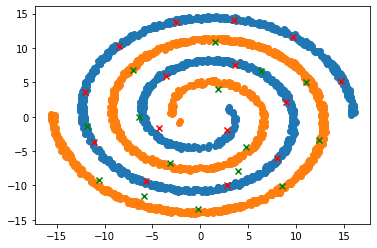

In [10]:
plt.figure()
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.scatter(means_em1[:,0],means_em1[:,1],c='r',marker='x')
plt.scatter(means_em2[:,0],means_em2[:,1],c='g',marker='x')

plt.show()

In [29]:
mypdf = []
for i in range(k):
    mypdf.append(muno.pdf(train_data_classes[0,:,0:2],means_em1[i],covs_em1[i]))

(1250,)


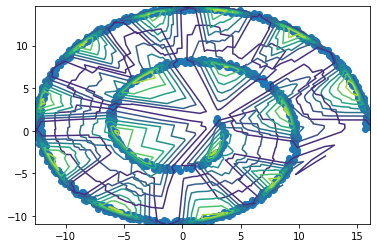

In [30]:
from matplotlib.tru import Triangulation as trii
print(mypdf[0].shape)
for i in range(k):
    teh = trii(train_data_classes[0,:,0],train_data_classes[0,:,1])
    plt.tricontour(tri ,mypdf[i])
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.show()

In [ ]:
# TODOs

# TODO Synthetic: Fit a GMM on each class, test
# TODO Synthetic: Plot of data + contours + filled in class boundaries
# TODO Synthetic: Vary K, diag and non-diag covariances.
# TODO Synthetic: Normalize the dataset, then do all of the above 
# TODO Synthetic: Get ROC, DET for each expt
# TODO Image: Figure out the features, how to organise them etc. Then do all of the above